# 1. Business Objectives

- Objective function		 	 	 		
- Any metric you wish to optimize in addition to accuracy 
- The intended user 
- Any business rules you think will be important 
- Performance requirements (time and/or complexity) 
- And more (for example: interpretability, diversity, novelty, etc) 		

# 2. Model Exploration & Evaluation 

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from item_based_cf import *
from metrics_helper import *

In [4]:
df = pd.read_csv('./ml-latest/ratings.csv')
df.drop("timestamp", inplace=True, axis=1)

The number of unique users is 283228
The number of unique items is 53889
The sparsity is 99.818%


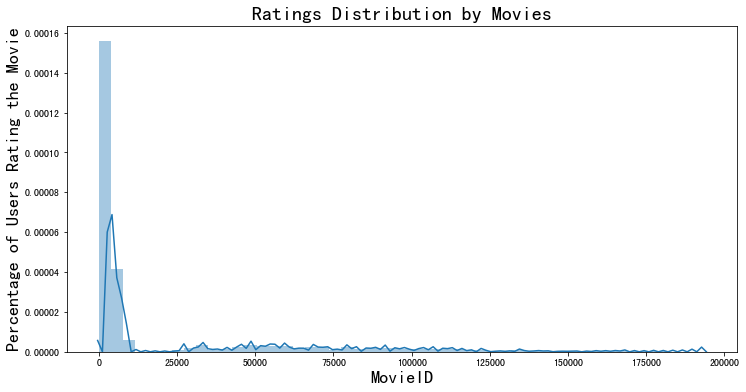

In [3]:
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
sparsity = round(1.0-len(df)/float(n_users*n_items),5)
print(f'The number of unique users is {n_users}')
print(f'The number of unique items is {n_items}')
print(f'The sparsity is {sparsity*100}%')

fig, ax = plt.subplots(figsize=(12,6))
fig = sns.distplot(df['movieId'])
ax.set_ylabel('Percentage of Users Rating the Movie', size=18)
ax.set_xlabel('MovieID', size=18)
ax.set_title('Ratings Distribution by Movies', size=20)
plt.show()

## 2.1 Memory-based Collaborative Filtering

### 2.1.1 Data preprocessing

In [4]:
##default param is 300 and 6800, which can satisfy hw requirement, and it takes about 6 hours to train and predict
df_sample = sample_df(df, min_item=2000, min_user=10000)

number of users: 423
number of items: 685
shape of sampled df: (215855, 3)


In [5]:
train_set, test_set = train_test_split(df_sample, test_size=0.50)
train_set, valid_set = train_test_split(train_set, test_size=0.2)
rating_matrix_train = train_set.pivot(index='movieId', columns='userId', values='rating')
rating_matrix_test = test_set.pivot(index='movieId', columns='userId', values='rating')

### 2.1.2 Model Training 

In [6]:
model1 = ItemBasedCF(100, 'pearson')

In [7]:
start = time.time()
model1.train(rating_matrix_train)
end = time.time()
print(f'training_time{end-start}')

training_time213.83071613311768


### 2.1.3 Model Tuning with Cross validation

In [8]:
model1.train_set

array([[3.5, 5. , 5. , ..., 5. , 2. , 4.5],
       [nan, nan, 3.5, ..., 3. , nan, nan],
       [nan, 2.5, 4. , ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, 3.5],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, 4.5, nan, ..., nan, nan, nan]])

In [18]:
pred_set = model1.predict(rating_matrix_test)

In [20]:
rating_matrix_test

userId,1272,2025,2150,2294,2329,2551,2629,4027,4605,4796,...,276799,277685,278022,278420,280148,280585,280868,281631,281790,283000
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,2.5,...,4.5,NaN,2.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN
2,NaN,2.0,NaN,NaN,3.0,1.0,3.5,4.0,1.5,NaN,...,3.0,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.5,NaN,NaN,2.5,NaN,NaN,NaN
5,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.5,NaN,3.5,3.0,NaN,NaN,NaN,NaN,3.5
6,NaN,NaN,4.5,3.5,NaN,2.0,NaN,5.0,NaN,3.5,...,NaN,3.0,NaN,NaN,NaN,4.5,4.0,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122882,NaN,5.0,NaN,3.0,3.5,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,4.5
122886,2.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.5,NaN,NaN,3.5,NaN,NaN,4.5
122904,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN


### 2.1.4 Model Evaluation

- ROC-based metrics (recall, precision, roc curve, auc)
- DCG
- coverage
- scalability

In [21]:
MAE(rating_matrix_test, pred_set)

0.6885897602816633

In [22]:
MSE(rating_matrix_test, pred_set)

0.7899858612161919

In [28]:
def dcg(test, pred):
    m = test.shape[1]
    sorted_pred = -np.sort(-pred, axis=0)
    sorted_indice = np.argsort(-pred, axis=0)
    sorted_test = np.zeros(test.shape)
    ranking = np.zeros(test.shape)
    for i in range(m):
        sorted_test[:, i] = test[:, i][sorted_indice[:, i]]
        ranking[:, i] = i + 1
    return np.mean(np.nansum((np.where(np.isnan(sorted_test), np.nan, 1))/np.log2(ranking+1), axis=1))

In [29]:
dcg(rating_matrix_test.values, pred_set)

22.91174836018709

### 2.1.5 Reflection

- Other design choices to consider?

## 2.2 Model-based  Collaborative Filtering

### 2.2.1 Data preprocessing

In [25]:
#initialize spark 
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark ML Basics").getOrCreate()

#process data into dataframe format 
df = spark.read.format('csv').options(header='true').load('../ml-latest/ratings.csv').toDF("userId",  "movieId",  "rating",   "timestamp")

from pyspark.sql.functions import *
from pyspark.sql.types import *


df = df.withColumn("userId", df["userId"].cast(IntegerType())). \
withColumn("movieId", df["movieId"].cast(IntegerType())). \
withColumn("rating",df["rating"].cast(FloatType())). \
withColumn("timestamp", df['timestamp'].cast(LongType()))

In [26]:
df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3.5|1256677221|
|     1|    481|   3.5|1256677456|
|     1|   1091|   1.5|1256677471|
|     1|   1257|   4.5|1256677460|
|     1|   1449|   4.5|1256677264|
+------+-------+------+----------+
only showing top 5 rows



In [27]:
#sampling data  
sample_df = df.sample(False,0.5,1234)
sample_df.createOrReplaceTempView("sample") 

print('number of users')
spark.sql("select count(1) from (select userId from sample GROUP BY userId)").show()

print('number of itesm')
spark.sql("select count(1) from (select movieId from sample GROUP BY movieId)").show()



number of users
+--------+
|count(1)|
+--------+
|  278301|
+--------+

number of itesm
+--------+
|count(1)|
+--------+
|   46487|
+--------+



In [28]:
#train test split 
train,test=sample_df.randomSplit((0.8,0.2),seed=1234)

### 2.2.2 Model Training

<h4> basic model

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)


Root-mean-square error = 0.8928828461776946


### 2.2.3 Model Tuning with Cross validation

In [42]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 


paramGrid = ParamGridBuilder() \
    .addGrid(als.maxIter,[5,10,20]) \
    .addGrid(als.regParam, [0.1, 0.01,0.001]) \
    .build()

crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction"),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)


# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)
# selected = prediction.select("id", "text", "probability", "prediction")
# for row in selected.collect():
#     print(row)

In [86]:
cvModel.avgMetrics

[0.8454584609257964,
 0.9196519032292239,
 1.022924058753338,
 0.8381039338587579,
 0.9285265085211727,
 0.9816080466031223,
 0.8357515044209932,
 0.9300277980962379,
 1.0009818882812291]

In [88]:
cvModel.getEstimatorParamMaps()           

[{Param(parent='ALS_e85142a41611', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='ALS_e85142a41611', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='ALS_e85142a41611', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='ALS_e85142a41611', name='regParam', doc='regularization parameter (>= 0).'): 0.01},
 {Param(parent='ALS_e85142a41611', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='ALS_e85142a41611', name='regParam', doc='regularization parameter (>= 0).'): 0.001},
 {Param(parent='ALS_e85142a41611', name='maxIter', doc='max number of iterations (>= 0).'): 10,
  Param(parent='ALS_e85142a41611', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='ALS_e85142a41611', name='maxIter', doc='max number of iterations (>= 0).'): 10,
  Param(parent='ALS_e85142a41611', name='regParam', doc='regularization parameter (>= 0).'): 0.01},
 {Param(parent='ALS_e851

### 2.2.4 Model Evaluation

- ROC-based metrics (recall, precision, roc curve, auc)
- DCG
- coverage
- scalability

### 2.2.5 Reflection

- Other design choices to consider?

# 3. Final Recommendation

- Final recommendation to your manager
- Reasons and potential watch outs 